# Map Matching

## 1 Road network downloading

### 1.1 Raw network

In [1]:
import os
import numpy as np
import pandas as pd

# load trajectory
read_path = 'data/1-processed/'
traj_files = os.listdir(read_path)
traj = pd.read_csv(read_path + traj_files[0])

# get boundary
north, south, east, west = traj['lat'].max(), traj['lat'].min(), traj['lon'].max(), traj['lon'].min()
north, south, east, west

(31.963024043263182, 31.83925187558819, 118.82577076985432, 118.77469900091182)

In [6]:
north = 31.97
south = 31.80
west = 118.75
east = 118.85

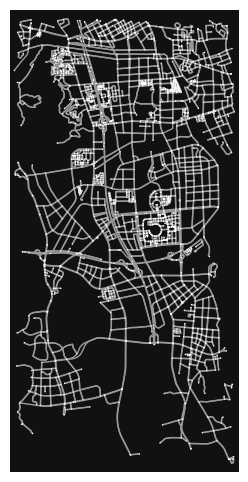

In [7]:
import osmnx as ox

# download network
custom_filter = ('["highway"]["area"!~"yes"]["access"!~"private"]'
                 '["highway"!~"abandoned|bridleway|bus_guideway|construction|corridor|cycleway|'
                 'elevator|escalator|footway|path|pedestrian|planned|platform|proposed|raceway|steps|track"]'
                 '["service"!~"emergency_access|private"]')
graph = ox.graph_from_bbox(
    north, south, east, west,
    simplify=True,
    custom_filter=custom_filter,
)

# plot
ox.plot_graph(graph, node_size=1, figsize=(6,6))

# save as geodataframe
edges = ox.graph_to_gdfs(graph, nodes=False)
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)

### 1.2 Simplify and save

In [11]:
nodes_sim = nodes.reset_index()[['osmid', 'geometry', 'street_count']]
nodes_sim.columns = ['node_id', 'geometry', 'street_n']
nodes_sim.to_file("data/0-roadnet/roadnet/nodes.shp")

In [9]:
edges_sim = edges.reset_index()[['u', 'v', 'oneway', 'reversed', 'highway', 'length', 'geometry']]

# set direction
def direction(oneway, reversed):
    """
    Determine the direction of link accroding to oneway and reversed.
    """
    if oneway:
        if reversed:
            return -1
        else:
            return 1
    else:
        return 0
    
edges_sim['dir'] = edges_sim.apply(lambda x: direction(x['oneway'], x['reversed']), axis=1)

# highway types
highway_types = ["motorway", "trunk", "primary", "secondary", "tertiary", "unclassified", "residential",
                 "motorway_link", "trunk_link", "primary_link", "secondary_link", "tertiary_link", "living_street",
                 "service"]
def highway_merge(highway):
    """
    Merge highway types accroding to levels.
    """
    if type(highway) == str:
        return highway
    else:
        # if there are two or more than highway types in the list, return the one with the highest class
        index = [highway_types.index(i) for i in highway]
        return highway[np.argmin(index)]
edges_sim['highway'] = edges_sim['highway'].apply(highway_merge)

# change to GoTrackIt form
edges_sim['link_id'] = edges_sim.index + 1
edges_sim = edges_sim[['link_id', 'u', 'v', 'dir', 'length', 'geometry', 'highway']]
edges_sim.columns = ['link_id', 'from_node', 'to_node', 'dir', 'length', 'geometry', 'highway']
edges_sim.to_file("data/0-roadnet/roadnet/edges.shp")

### 1.3 Select route

Using `select_route.py` to choose all edges in the route. After this, we should select the corresponding nodes.

In [16]:
import geopandas as gpd
# load edges
selected_edges = gpd.read_file("data/0-roadnet/route/selected_lines.shp")
# find all nodes
valid_ids = pd.concat([selected_edges['from_node'], selected_edges['to_node']]).unique()
selected_nodes = nodes_sim[nodes_sim['node_id'].isin(valid_ids)]
selected_nodes = selected_nodes.reset_index(drop=True)
selected_nodes.to_file("data/0-roadnet/route/selected_nodes.shp")

---

## 2 Map-matching

## 2.1 Data preperation

#### 2.1.1 Trajectory

In [18]:
import os
import pandas as pd

# load trajectory
read_path = 'data/1-processed/'
traj_files = os.listdir(read_path)
trajs = {}
for traj_file in traj_files:
    key = traj_file.split('.')[0]
    trajs[key] = pd.read_csv(read_path + traj_file)

In [19]:
trajs['Avalon-DRIVER1']

,sec of day,sec,lon,lat,speed[km/h],alt[m],true_north[D],pad_pressure,d_gap[m],t_gap[s],grade[D],acc[m/s2],VSP[kW/t],temp[C],humd,pressure[hPa],v_wind[km/h],d_wind[D],trac_power[kW]
0,52651.0,0,118.820160,31.896037,0.000000,4.60,0.00,5,0.015122,1.0,0.0000,0.000000,0.000000,12,0.66,1022,8,294,0.000000
1,52652.0,1,118.820160,31.896037,0.000000,4.60,0.00,3,0.024825,1.0,0.0000,0.000000,0.000000,12,0.66,1022,8,294,0.000000
2,52653.0,2,118.820161,31.896037,0.000000,4.60,0.00,1,0.002758,1.0,0.0000,0.000000,0.000000,12,0.66,1022,8,294,0.000000
3,52654.0,3,118.820161,31.896037,0.000000,4.60,0.00,1,0.019590,1.0,0.0000,0.000000,0.000000,12,0.66,1022,8,294,0.000000
4,52655.0,4,118.820161,31.896037,0.000000,4.60,0.00,0,0.004080,1.0,0.0000,0.000000,0.000000,12,0.66,1022,8,294,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,55703.0,3052,118.819528,31.896037,0.219100,8.03,80.70,22,0.080989,1.0,0.3496,-0.042600,0.208100,12,0.67,1022,8,304,0.012460
3053,55704.0,3053,118.819528,31.896036,0.065730,8.01,80.56,21,0.078583,1.0,0.2850,-0.012790,0.051970,12,0.67,1022,8,304,0.004320
3054,55705.0,3054,118.819528,31.896035,0.019730,8.00,80.50,12,0.075806,1.0,0.2094,-0.003836,0.011720,12,0.67,1022,8,304,0.001259
3055,55706.0,3055,118.819528,31.896034,0.005917,8.00,80.50,5,0.060263,1.0,0.1849,-0.001151,0.003132,12,0.67,1022,8,304,0.000373


#### 2.1.2 Road net

In [11]:
import geopandas as gpd

link = gpd.read_file("data/0-roadnet/route/selected_lines.shp")
node = gpd.read_file("data/0-roadnet/route/selected_nodes.shp")
link = link.to_crs('EPSG:4326')
node = node.to_crs('EPSG:4326')

In [12]:
from keplergl import KeplerGl
map = KeplerGl(height=800, config={'mapState':{'latitude':31.93066, 'longitude':118.80351 , 'zoom':11}}) 
map.add_data(data=link, name='links')
map.add_data(data=node, name='nodes')
map.save_to_html(file_name='data/0-roadnet/roadnet/roadnet.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to data/0-roadnet/roadnet/roadnet.html!


### 2.2 Matching

In [13]:
from gotrackit.map.Net import Net
from gotrackit.MapMatch import MapMatch

In [14]:
# initialize map
my_net = Net(link_gdf=link, node_gdf=node, not_conn_cost=1200)
my_net.init_net()

__init__ costs :0.023134946823120117 seconds!


#### 2.2.1 Test

In [6]:
# initialize trajectory
traj = trajs['Avalon-DRIVER1'][['lon', 'lat', 'sec']].copy()
traj.columns = ['lng', 'lat', 'time']
traj['agent_id'] = 0

In [8]:
mpm = MapMatch(net=my_net, flag_name='Avalon-DRIVER1',
               gps_buffer=100, top_k=20,
               use_sub_net=True, dense_gps=False, use_heading_inf=False,
               export_html=True, gps_radius=15.0, export_all_agents=False,
               out_fldr="data/2-mapmatched/test")
match_res, warn_info, error_info = mpm.execute(gps_df=traj.loc[5:].copy())

- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.002243518829345703 seconds!
create_computational_net costs :0.017343521118164062 seconds!
do not use prj_cache
__generate_st costs :0.7175679206848145 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 1932 -> 1933 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2250 -> 2251 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Map saved to data/2-mapmatched/test\Avalon-DRIVER1-0.html!
export_visualization costs :1.614837646484375 seconds!


#### 2.2.2 Match

In [15]:
from gotrackit.map.Net import Net
from gotrackit.MapMatch import MapMatch

In [16]:
for key, traj in trajs.items():

    print("#" * 30)
    print("Execute file: %s" % key)

    # initialize traj data
    traj_ = traj[['lon', 'lat', 'sec']].copy()
    traj_.columns = ['lng', 'lat', 'time']
    traj_['agent_id'] = 0

    # set mapmatching config
    mpm = MapMatch(
        net=my_net, flag_name=key,
        gps_buffer=100, top_k=20,
        use_sub_net=True, dense_gps=False, use_heading_inf=False,
        export_html=False
    )
    # execute
    result, warn_info, error_info = mpm.execute(gps_df=traj_)

    # simplify result
    result = result[['time', 'link_id']]
    result['time'] = result['time'].apply(lambda x: int(x.timestamp()))
    result.columns = ['sec', 'link_id']

    # merge data
    traj = pd.merge(left=traj, right=result, on='sec', how='left')
    traj = pd.merge(left=traj, right=link[['link_id', 'highway']], on='link_id', how='left')
    trajs[key] = traj.dropna().reset_index(drop=True)

##############################
Execute file: Avalon-DRIVER1
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0029997825622558594 seconds!
create_computational_net costs :0.01700139045715332 seconds!
do not use prj_cache
__generate_st costs :0.709660530090332 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 1937 -> 1938 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2255 -> 2256 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Avalon-DRIVER2
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0 seconds!
create_computational_net costs :0.015593767166137695 seconds!
do not use prj_cache
__generate_st costs :1.037121295928955 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2113 -> 2114 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2367 -> 2368 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Corolla-DRIVER1
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0024919509887695312 seconds!
create_computational_net costs :0.015991687774658203 seconds!
do not use prj_cache
__generate_st costs :0.8594272136688232 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2166 -> 2167 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2433 -> 2434 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Corolla-DRIVER2
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.003995180130004883 seconds!
create_computational_net costs :0.023004531860351562 seconds!
do not use prj_cache
__generate_st costs :0.9952163696289062 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2327 -> 2328 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2651 -> 2652 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Ei5-DRIVER1
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.002547740936279297 seconds!
create_computational_net costs :0.01977372169494629 seconds!
do not use prj_cache
__generate_st costs :1.0088131427764893 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2460 -> 2461 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2679 -> 2680 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Ei5-DRIVER2
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.003003835678100586 seconds!
create_computational_net costs :0.017395973205566406 seconds!
do not use prj_cache
__generate_st costs :0.9043130874633789 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2260 -> 2261 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2483 -> 2484 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: ModelY-DRIVER1
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0028045177459716797 seconds!
create_computational_net costs :0.02197885513305664 seconds!
do not use prj_cache
__generate_st costs :0.8975846767425537 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2222 -> 2223 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2563 -> 2564 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: ModelY-DRIVER2
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0019676685333251953 seconds!
create_computational_net costs :0.018229961395263672 seconds!
do not use prj_cache
__generate_st costs :0.8350811004638672 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2222 -> 2223 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2444 -> 2445 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Sylphy-DRIVER1
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0010967254638671875 seconds!
create_computational_net costs :0.017513513565063477 seconds!
do not use prj_cache
__generate_st costs :0.8883345127105713 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2287 -> 2288 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2554 -> 2555 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: Sylphy-DRIVER2
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.002000093460083008 seconds!
create_computational_net costs :0.01649928092956543 seconds!
do not use prj_cache
__generate_st costs :0.8760597705841064 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2097 -> 2098 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2364 -> 2365 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: TiguanL-DRIVER1
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0026938915252685547 seconds!
create_computational_net costs :0.018285751342773438 seconds!
do not use prj_cache
__generate_st costs :0.8052470684051514 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 1982 -> 1983 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2203 -> 2204 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


##############################
Execute file: TiguanL-DRIVER2
- gotrackit ------> No.1: agent: 0 
time column does not match format %Y-%m-%d %H:%M:%S, try using time-unit: s
using sub net
__init__ costs :0.0019998550415039062 seconds!
create_computational_net costs :0.02390742301940918 seconds!
do not use prj_cache
__generate_st costs :1.05063796043396 seconds!


d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2260 -> 2261 problem with state transfer
                            from_link:(-1075523042, -1075523041) -> to_link:(-1075523040, -67471233)
  warnings.warn(
d:\Software\Anaconda3\envs\gotrackit\Lib\site-packages\gotrackit\model\Markov.py:1100: UserWarning: gps seq: 2576 -> 2577 problem with state transfer
                            from_link:(-67471233, 243986176) -> to_link:(2013888817, -935820707)
  warnings.warn(


In [17]:
# save
for key, traj in trajs.items():
    traj.to_csv("data/2-mapmatched/%s.csv" % key, index=False)

---

## 3 Visualize

In [14]:
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_route(df):
    fig, ax = plt.subplots(figsize=(12, 8))  # 可根据需要调整大小
    df['geometry'] = df.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.plot(
        column='highway',
        ax=ax,
        markersize=0.5,  # 调整点的大小，值越小点越小
        cmap='Set1',  # 选择颜色映射
        legend=True,  # 显示图例
        legend_kwds={
            'loc': 'center left',  # 图例位置在左侧中间
            'bbox_to_anchor': (1, 0.5),  # 将图例放置在图形右侧中间
            'fontsize': 8,  # 图例字体大小
            'ncol': 1  # 图例从上到下排列
        }
    )
    plt.rcParams['figure.dpi'] = 150  # 可根据需要调整 DPI 值，值越大越清晰
    plt.show()

Avalon-DRIVER1


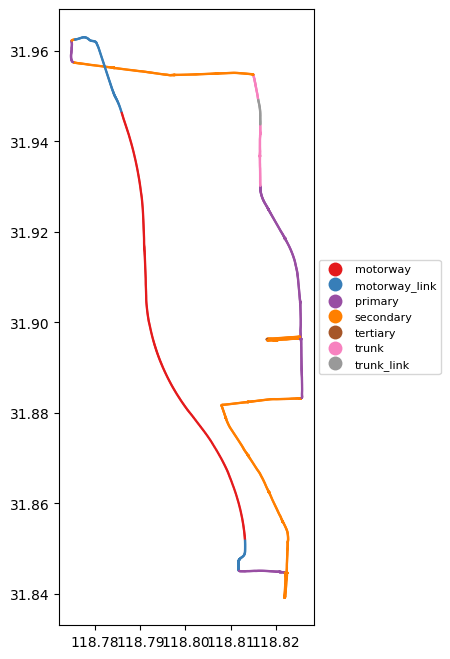

Avalon-DRIVER2


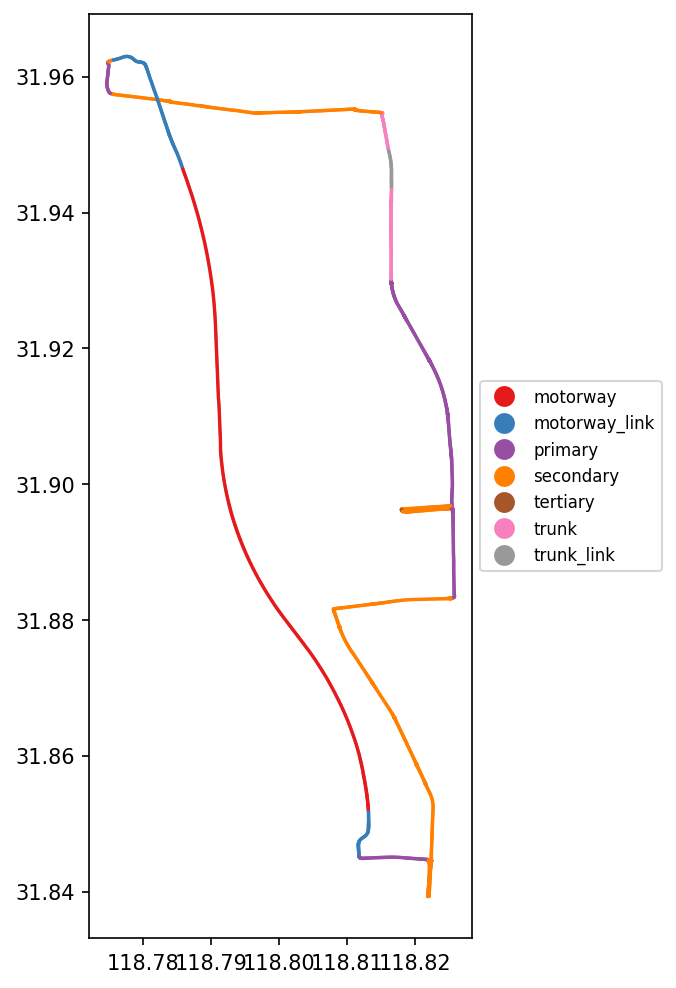

Corolla-DRIVER1


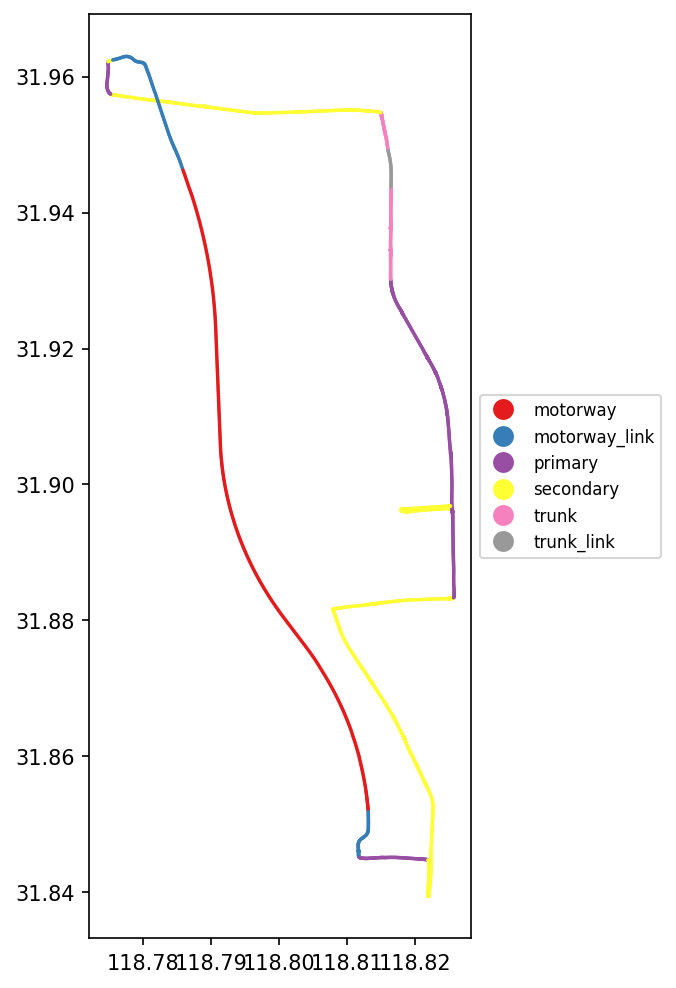

Corolla-DRIVER2


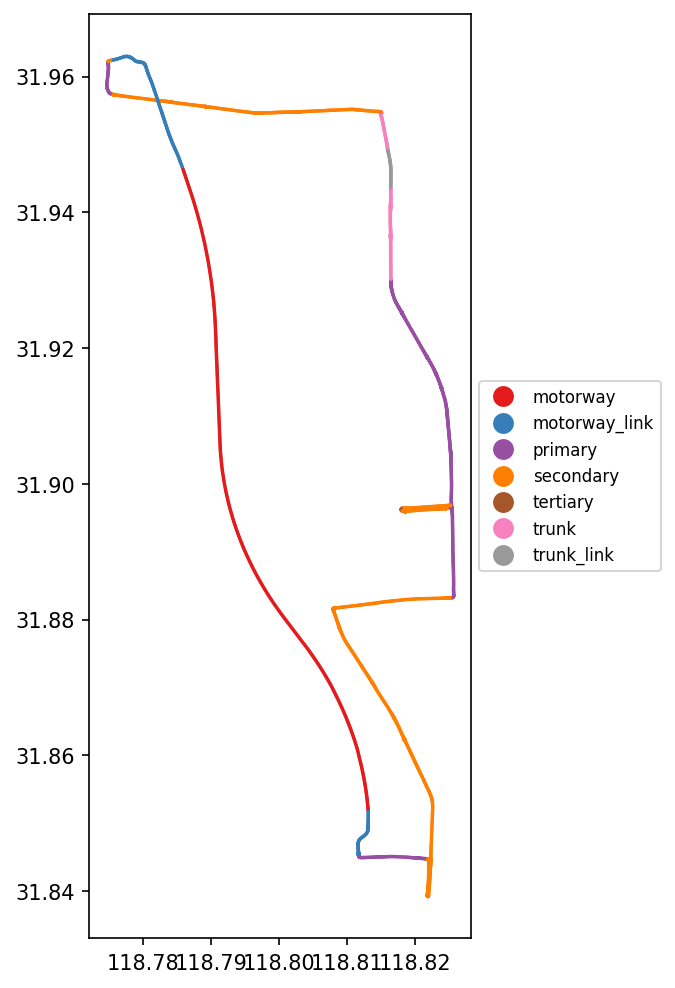

Ei5-DRIVER1


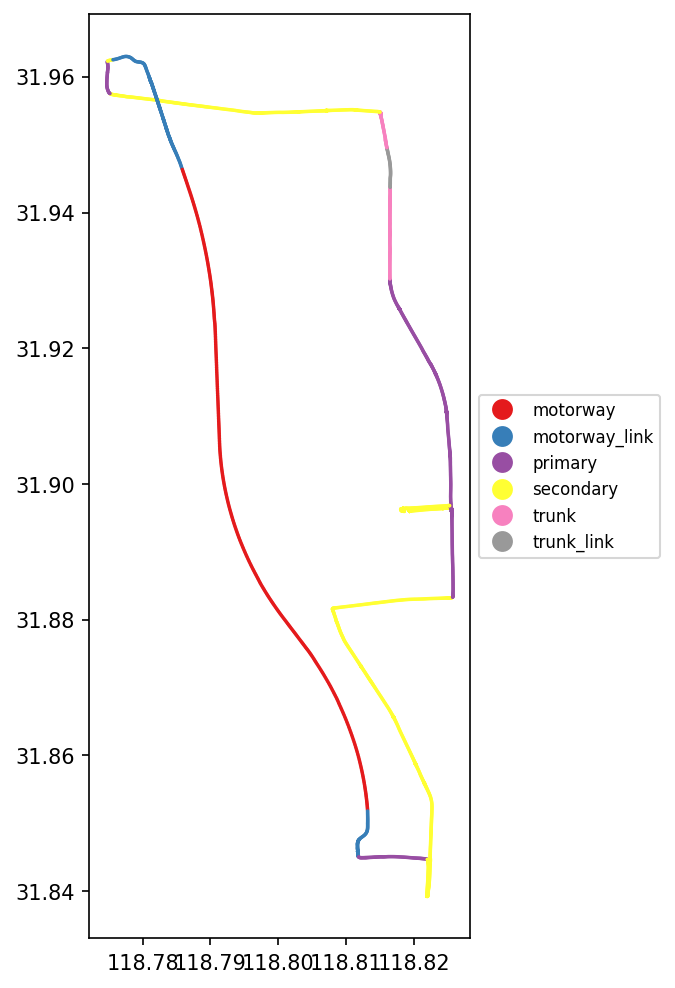

Ei5-DRIVER2


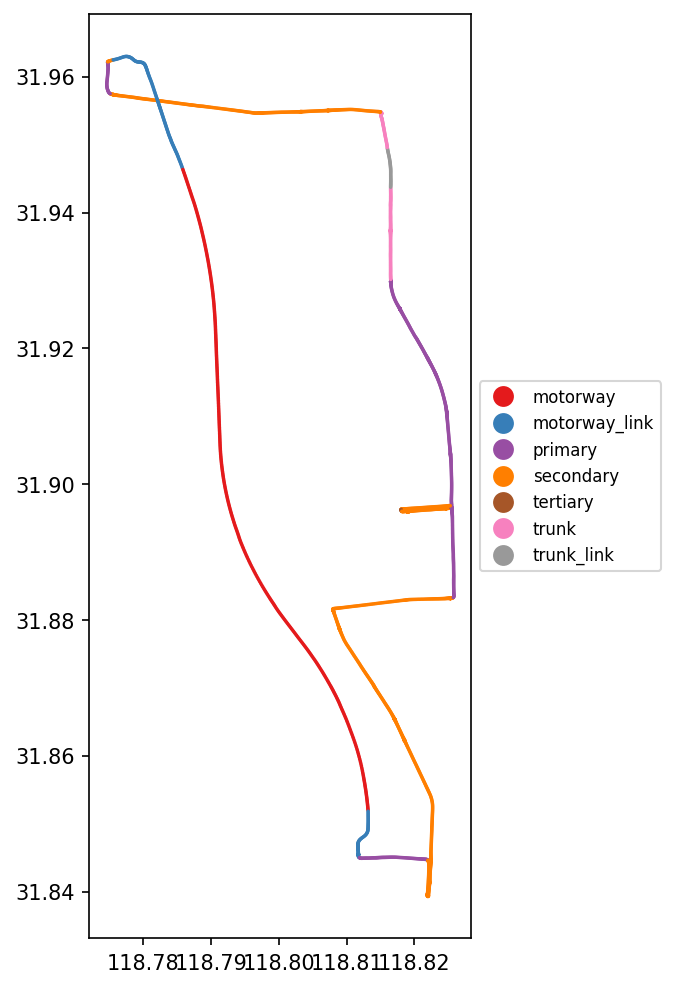

ModelY-DRIVER1


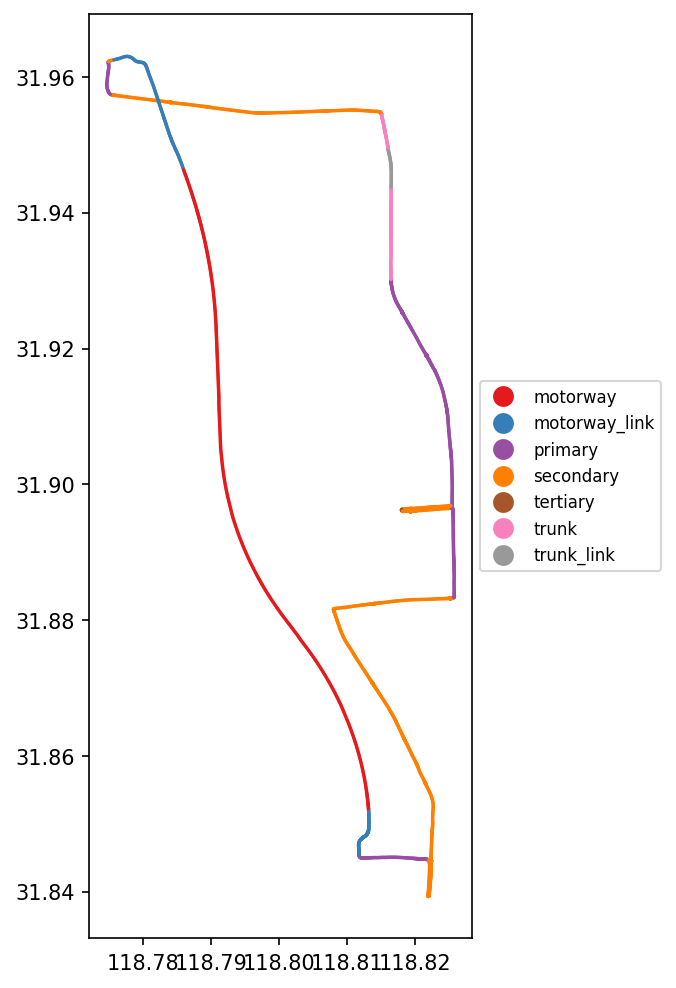

ModelY-DRIVER2


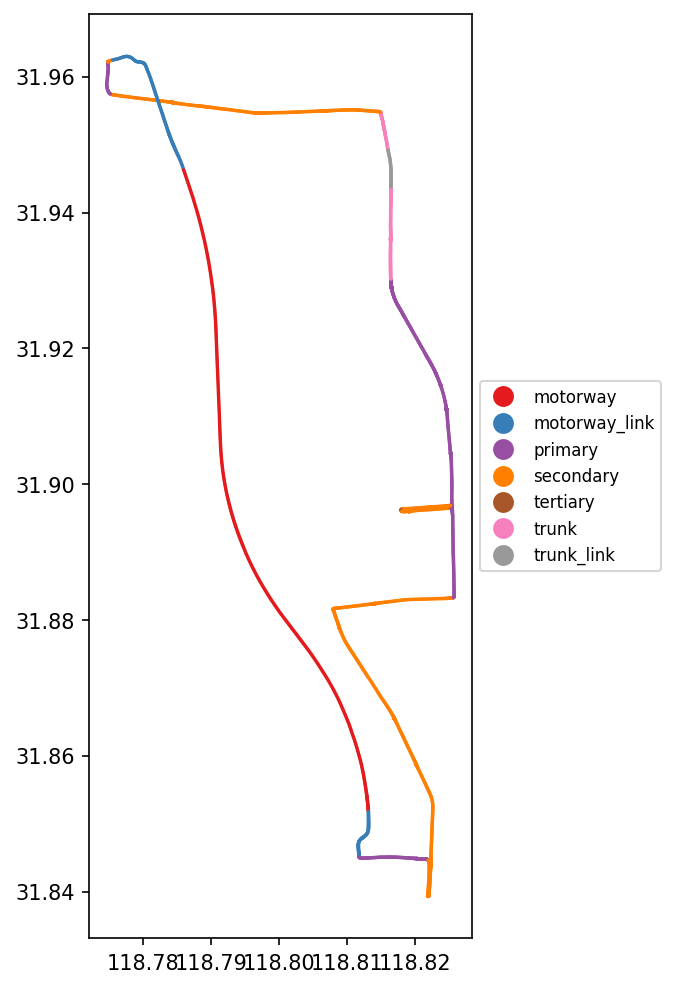

Sylphy-DRIVER1


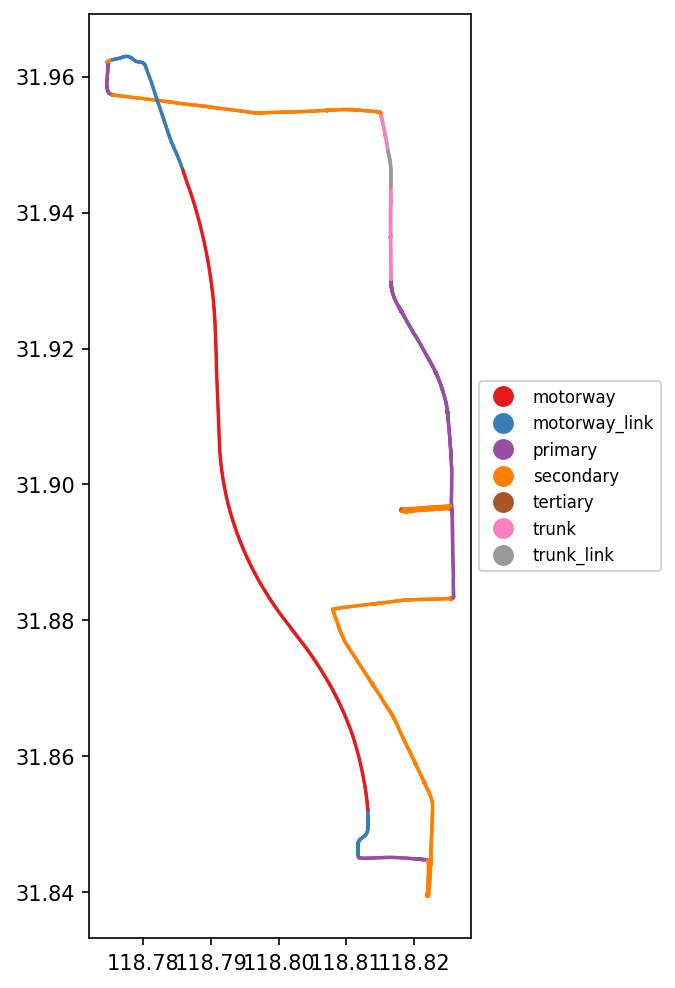

Sylphy-DRIVER2


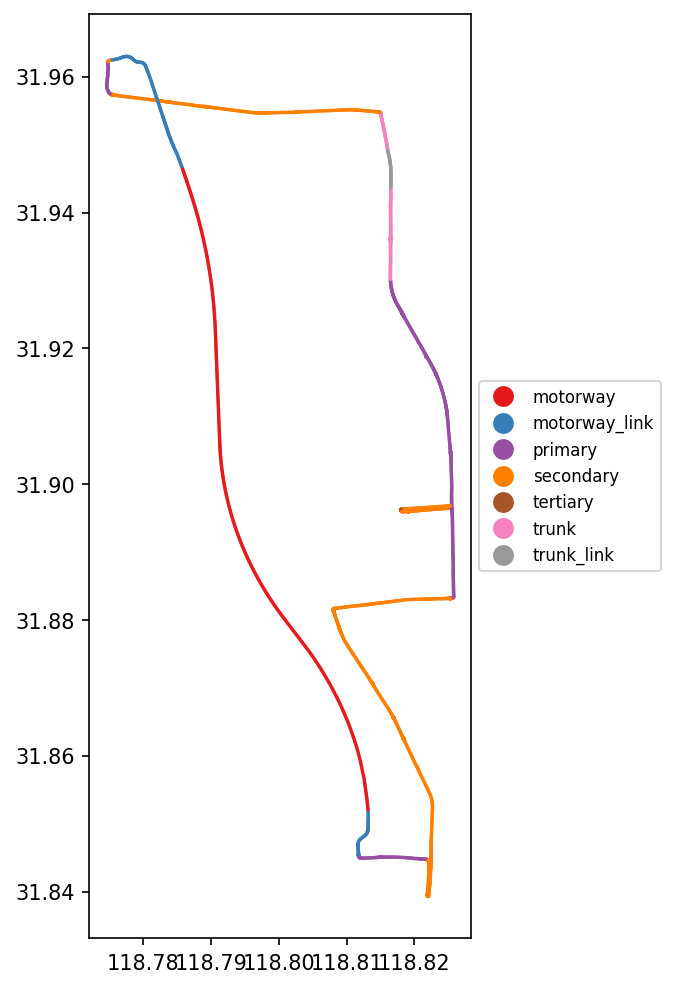

TiguanL-DRIVER1


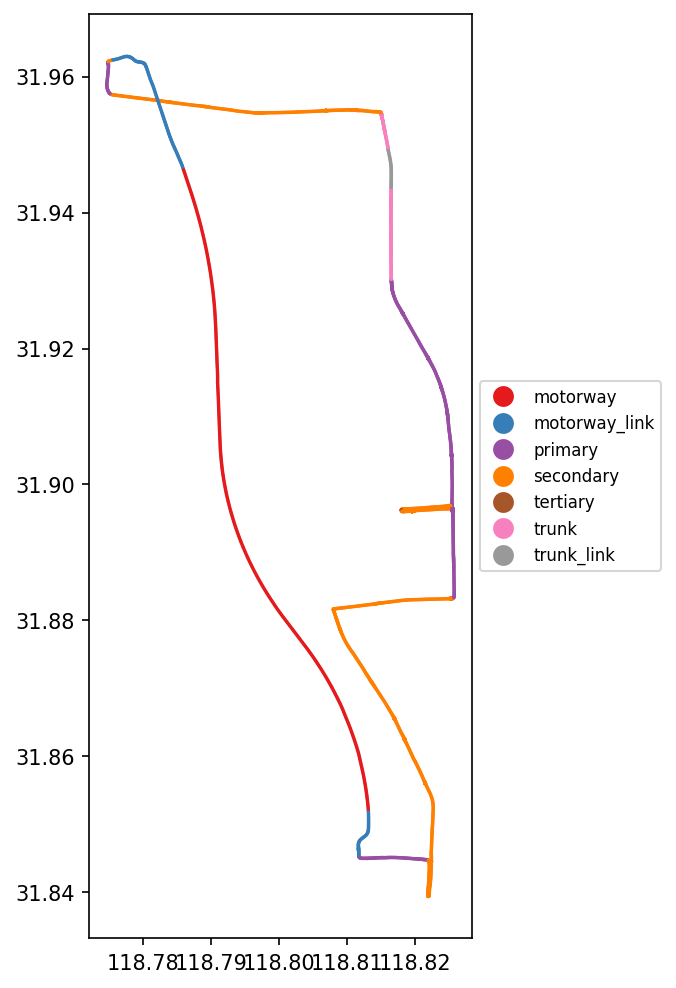

TiguanL-DRIVER2


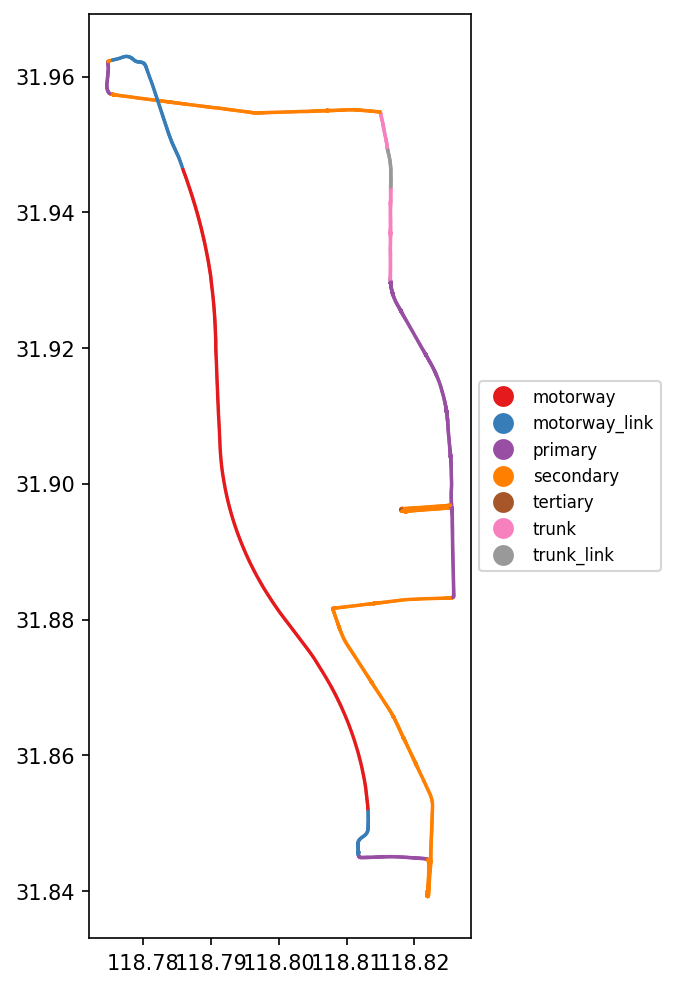

In [15]:
for key, traj in trajs.items():
    print(key)
    plot_route(traj)